### Libraries

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *

### Generate 3DoF Dataset

In [2]:
# seed random generator
torch.manual_seed(0)

# choose robot alongside joint limits
robot_choice = "3DoF-R"
q_lim = torch.tensor([[-torch.pi, torch.pi],
                      [-torch.pi, torch.pi],
                      [-torch.pi, torch.pi]])

# generate dataset with a specified number of samples
n_samples = 10000
data_position = []
for _ in range(n_samples):
    t = torch.distributions.uniform.Uniform(q_lim[:,0], q_lim[:,1]).sample()
    DH = get_DH(robot_choice, t)
    T = forward_kinematics(DH)
    if robot_choice == "3DoF-R":
        # x,y,t1,t2,t3 where x,y (m) and t (rad)
        data_position.append(torch.cat([T[:2,-1], t]).numpy())
      
data_position_a = np.array(data_position)


# save dataset
if robot_choice == "3DoF-R":
    header = ["x","y","t1","t2","t3"]
    
df = pd.DataFrame(data_position_a)
df.to_csv("data_"+robot_choice+".csv",
          index=False,
          header=header)

### Generate 4DoF Dataset

In [ ]:
# seed random generator
torch.manual_seed(0)

# choose robot alongside joint limits
robot_choice = "4DoF-2RPR"
q_lim = torch.tensor([[-torch.pi, torch.pi],
                      [-torch.pi, torch.pi],
                      [-0.7, 0.7]],
                      [-torch.pi, torch.pi]])

# generate dataset with a specified number of samples
n_samples = 10000
data_position = []
for _ in range(n_samples):
    t = torch.distributions.uniform.Uniform(q_lim[:,0], q_lim[:,1]).sample()
    DH = get_DH(robot_choice, t)
    T = forward_kinematics(DH)
    if robot_choice == "3DoF-R":
        # x,y,t1,t2,t3 where x,y (m) and t (rad)
        data_position.append(torch.cat([T[:2,-1], t]).numpy())
      
data_position_a = np.array(data_position)


# save dataset
if robot_choice == "3DoF-R":
    header = ["x","y","t1","t2","t3"]
    
df = pd.DataFrame(data_position_a)
df.to_csv("data_"+robot_choice+".csv",
          index=False,
          header=header)

### Visualize 3DoF Dataset

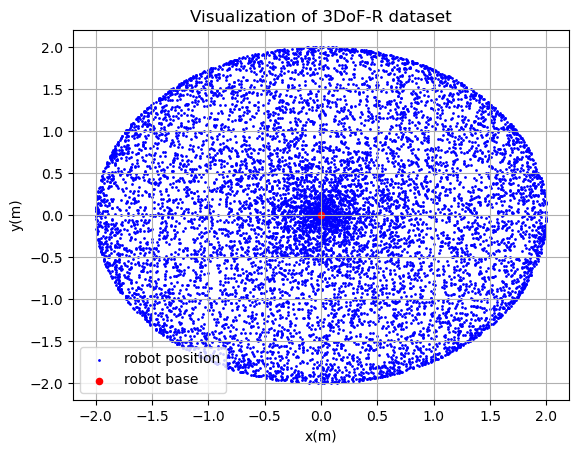

In [3]:
fig, ax = plt.subplots()
ax.scatter(data_position_a[:,0], data_position_a[:,1],s=1, marker='o', c='b')
ax.scatter(0,0,s=20, marker='o', c='r')
ax.set(xlabel='x(m)', ylabel='y(m)',
       title='Visualization of '+robot_choice+ ' dataset')
ax.legend(["robot position","robot base"])
ax.grid()

# Torch Training

Generation = 1
Fitness    = -1.571385383605957
Generation = 2
Fitness    = -1.571385383605957
Generation = 3
Fitness    = -1.571385383605957
Generation = 4
Fitness    = -1.571385383605957
Generation = 5
Fitness    = -1.5699213743209839
Generation = 6
Fitness    = -1.5699213743209839
Generation = 7
Fitness    = -1.568060278892517
Generation = 8
Fitness    = -1.568060278892517
Generation = 9
Fitness    = -1.5413222312927246
Generation = 10
Fitness    = -1.5413222312927246
Generation = 11
Fitness    = -1.5413222312927246
Generation = 12
Fitness    = -1.5413222312927246
Generation = 13
Fitness    = -1.5413222312927246
Generation = 14
Fitness    = -1.5220046043395996
Generation = 15
Fitness    = -1.5220046043395996
Generation = 16
Fitness    = -1.5220046043395996
Generation = 17
Fitness    = -1.5220046043395996
Generation = 18
Fitness    = -1.5220046043395996
Generation = 19
Fitness    = -1.5220046043395996
Generation = 20
Fitness    = -1.5073089599609375
Generation = 21
Fitness    = -1.507

Fitness    = -1.4848392009735107
Generation = 168
Fitness    = -1.4848392009735107
Generation = 169
Fitness    = -1.4848392009735107
Generation = 170
Fitness    = -1.4848392009735107
Generation = 171
Fitness    = -1.4848392009735107
Generation = 172
Fitness    = -1.4848392009735107
Generation = 173
Fitness    = -1.4848392009735107
Generation = 174
Fitness    = -1.4848392009735107
Generation = 175
Fitness    = -1.4848392009735107
Generation = 176
Fitness    = -1.4848392009735107
Generation = 177
Fitness    = -1.4848392009735107
Generation = 178
Fitness    = -1.4848392009735107
Generation = 179
Fitness    = -1.4848392009735107
Generation = 180
Fitness    = -1.4848392009735107
Generation = 181
Fitness    = -1.4848392009735107
Generation = 182
Fitness    = -1.4848392009735107
Generation = 183
Fitness    = -1.4848392009735107
Generation = 184
Fitness    = -1.4848392009735107
Generation = 185
Fitness    = -1.4848392009735107
Generation = 186
Fitness    = -1.4848392009735107
Generation = 187


Fitness    = -1.4848392009735107


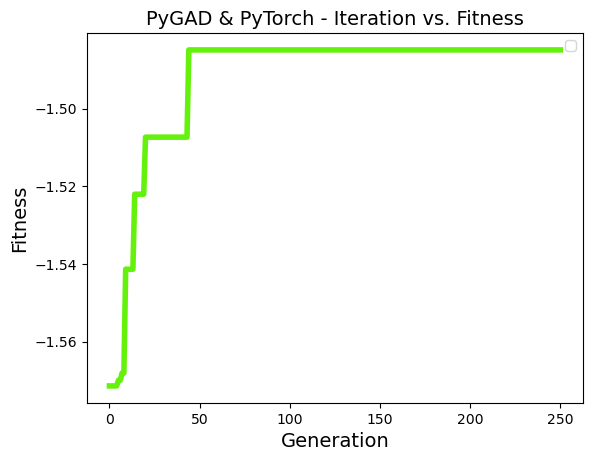

Fitness value of the best solution = -1.4848392009735107
Index of the best solution : 0
Predictions : 
 [[ 0.40376478  0.3074476  -0.3446847 ]
 [-1.4118807  -0.31802815  0.06877175]
 [ 0.40376478  0.3074476  -0.3446847 ]
 ...
 [-1.1391232  -0.45469552 -0.05581024]
 [ 0.40376478  0.3074476  -0.3446847 ]
 [ 0.40376478  0.3074476  -0.3446847 ]]
Absolute Error :  1.4848392


In [14]:
import torch
# import torchga
import pygad.torchga as torchga

def fitness_func(ga_instance, solution, sol_idx):
    global data_inputs, data_outputs, torch_ga, model, loss_function

    model_weights_dict = torchga.model_weights_as_dict(model=model,
                                                       weights_vector=solution)

    # Use the current solution as the model parameters.
    model.load_state_dict(model_weights_dict)

    predictions = model(data_inputs)
#     abs_error = loss_function(predictions, data_outputs).detach().numpy() + 0.00000001
    abs_error = loss_function(predictions, data_outputs).detach().numpy()

#     solution_fitness = 1.0 / abs_error
    solution_fitness = -abs_error

    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

# Create the PyTorch model.
input_layer = torch.nn.Linear(2, 5)
relu_layer = torch.nn.ReLU()
sigmoid_layer = torch.nn.Sigmoid()
h1 = torch.nn.Linear(5, 128)
h2 = torch.nn.Linear(128, 512)
h3 = torch.nn.Linear(512, 128)
h4 = torch.nn.Linear(128, 5)
output_layer = torch.nn.Linear(5, 3)

model = torch.nn.Sequential(input_layer,
                            sigmoid_layer,
                            h1,
                            sigmoid_layer,
                            h2,
                            sigmoid_layer,
                            h3,
                            sigmoid_layer,
                            h4,
                            relu_layer,
                            output_layer)
# print(model)

# Create an instance of the pygad.torchga.TorchGA class to build the initial population.
torch_ga = torchga.TorchGA(model=model,
                           num_solutions=10)

loss_function = torch.nn.L1Loss()

# Data inputs


training_data = data_position_a[:8000, :2]
testing_data = data_position_a[8000:, :2]

training_targets = data_position_a[:8000, 2:]
testing_targets = data_position_a[8000:, 2:]

data_inputs = torch.from_numpy(training_data)
data_outputs = torch.from_numpy(training_targets)

# data_inputs = torch.tensor([[0.02, 0.1, 0.15],
#                             [0.7, 0.6, 0.8],
#                             [1.5, 1.2, 1.7],
#                             [3.2, 2.9, 3.1]])

# # Data outputs
# data_outputs = torch.tensor([[0.1],
#                              [0.6],
#                              [1.3],
#                              [2.5]])

# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/pygad.html#pygad-ga-class
num_generations = 250 # Number of generations.
num_parents_mating = 5 # Number of solutions to be selected as parents in the mating pool.
initial_population = torch_ga.population_weights # Initial population of network weights

ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)

ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Fetch the parameters of the best solution.
best_solution_weights = torchga.model_weights_as_dict(model=model,
                                                      weights_vector=solution)
model.load_state_dict(best_solution_weights)
predictions = model(data_inputs)
print("Predictions : \n", predictions.detach().numpy())

abs_error = loss_function(predictions, data_outputs)
print("Absolute Error : ", abs_error.detach().numpy())

In [12]:
solution.shape

(148,)